In [ ]:

"""
-General workflow: EDA, VL extraction, Feature Extraction(DPC), Dimensionality Reduction, build functional model(SVM, Random Forest, Logistic Regression), then iterate and improve
-EDA: Sequences length, Amino Acid(AA) composition, Dipeptide composition, AlphaFold(for 3D structure)"""


'\n-General workflow: EDA, VL extraction, Feature Extraction(DPC), Dimensionality Reduction, build functional model(SVM, Random Forest, Logistic Regression), then iterate and improve\n-EDA: Sequences length, Amino Acid(AA) composition, Dipeptide composition, AlphaFold(for 3D structure)'

In [ ]:
pip install biopython matplotlib seaborn pandas numpy pymrmr scikit-learn


In [ ]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import itertools
import random
from sklearn.decomposition import PCA
import pandas as pd
import pymrmr
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Function to read sequences from a FASTA file
def read_fasta(file):
    sequences = []
    for record in SeqIO.parse(file, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Function to calculate sequence lengths
def sequence_length_distribution(sequences):
    lengths = [len(seq) for seq in sequences]
    return lengths

# Function to calculate amino acid composition
def amino_acid_composition(sequences):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    composition = {aa: 0 for aa in amino_acids}

    total_aa = sum(len(seq) for seq in sequences)

    for seq in sequences:
        for aa in seq:
            if aa in composition:
                composition[aa] += 1

    for aa in composition:
        composition[aa] /= total_aa

    return composition

# Function to calculate dipeptide composition
def dipeptide_composition(sequences):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    dipeptides = [''.join(p) for p in itertools.product(amino_acids, repeat=2)]
    dipeptide_counts = Counter()

    for seq in sequences:
        for i in range(len(seq) - 1):
            dipeptide = seq[i:i+2]
            if dipeptide in dipeptides:
                dipeptide_counts[dipeptide] += 1

    total_dipeptides = sum(dipeptide_counts.values())

    dipeptide_freq = {dipeptide: dipeptide_counts[dipeptide] / total_dipeptides for dipeptide in dipeptides}

    return dipeptide_freq

# Visualization Functions

def plot_length_distribution(lengths):
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, kde=True, color='blue', bins=30)
    plt.title('Sequence Length Distribution')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.show()

def plot_amino_acid_composition(composition):
    plt.figure(figsize=(10, 6))
    amino_acids = list(composition.keys())
    frequencies = list(composition.values())

    sns.barplot(x=amino_acids, y=frequencies, palette='viridis')
    plt.title('Amino Acid Composition')
    plt.xlabel('Amino Acid')
    plt.ylabel('Frequency')
    plt.show()

def plot_dipeptide_composition(dipeptide_freq):
    df = pd.DataFrame(list(dipeptide_freq.items()), columns=['Dipeptide', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Dipeptide', y='Frequency', data=df.head(20), palette='plasma')
    plt.title('Top 20 Dipeptides by Frequency')
    plt.xticks(rotation=90)
    plt.xlabel('Dipeptide')
    plt.ylabel('Frequency')
    plt.show()

# Main function to perform EDA
def perform_eda(fasta_file):
    sequences = read_fasta(fasta_file)

    # Sequence Length Distribution
    lengths = sequence_length_distribution(sequences)
    plot_length_distribution(lengths)

    # Amino Acid Composition
    aa_composition = amino_acid_composition(sequences)
    plot_amino_acid_composition(aa_composition)

    # Dipeptide Composition
    dipeptide_freq = dipeptide_composition(sequences)
    plot_dipeptide_composition(dipeptide_freq)

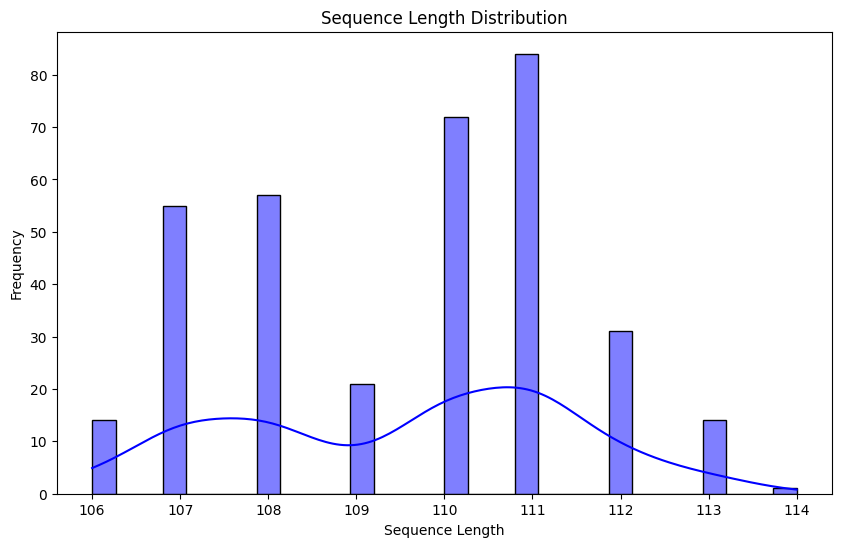

<ipython-input-3-0910df158ae7>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=amino_acids, y=frequencies, palette='viridis')


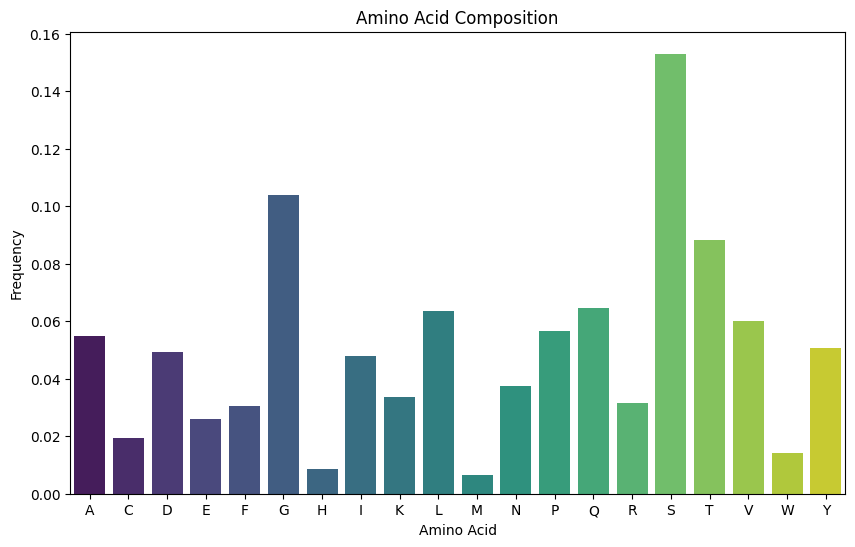

<ipython-input-3-0910df158ae7>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dipeptide', y='Frequency', data=df.head(20), palette='plasma')


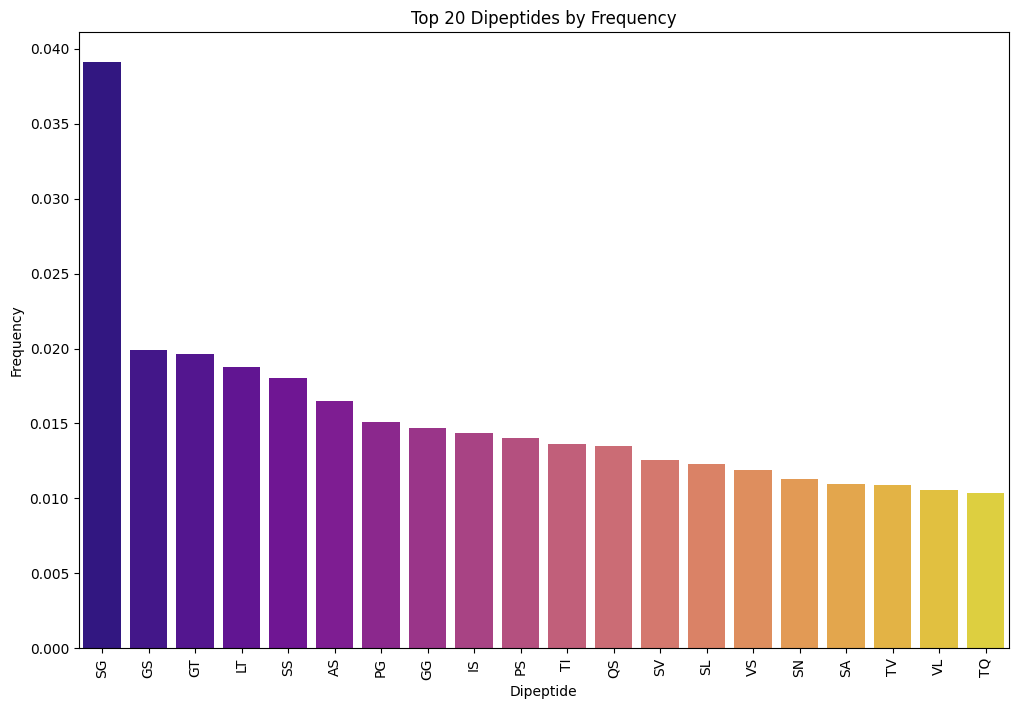

In [ ]:
# Example usage
fasta_file = 'Amyloid.fasta'
perform_eda(fasta_file)

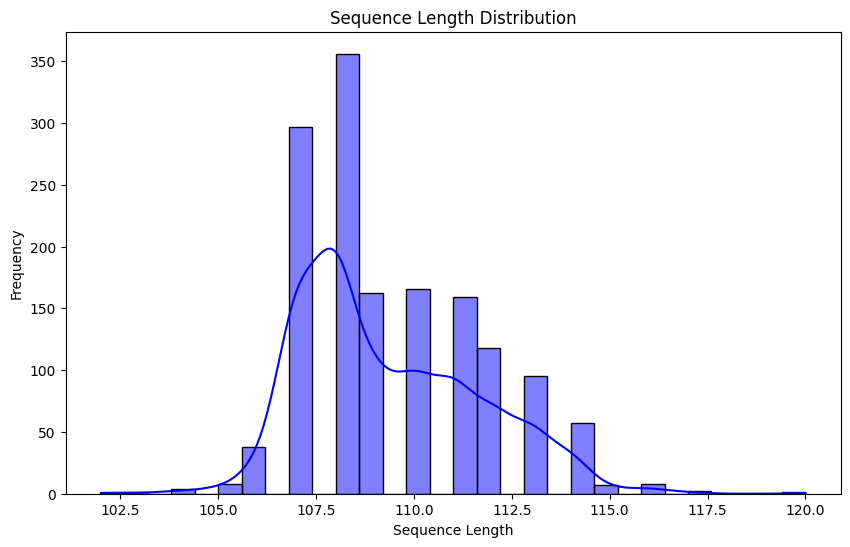

<ipython-input-3-0910df158ae7>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=amino_acids, y=frequencies, palette='viridis')


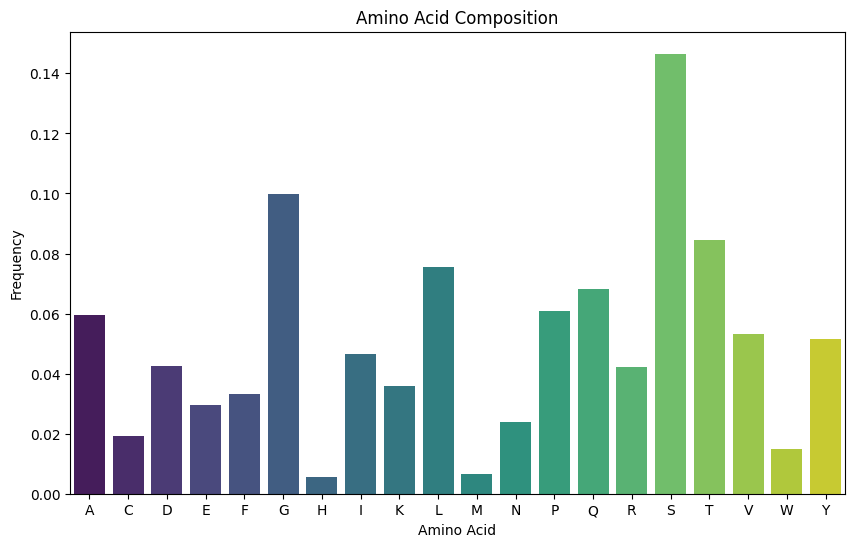

<ipython-input-3-0910df158ae7>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dipeptide', y='Frequency', data=df.head(20), palette='plasma')


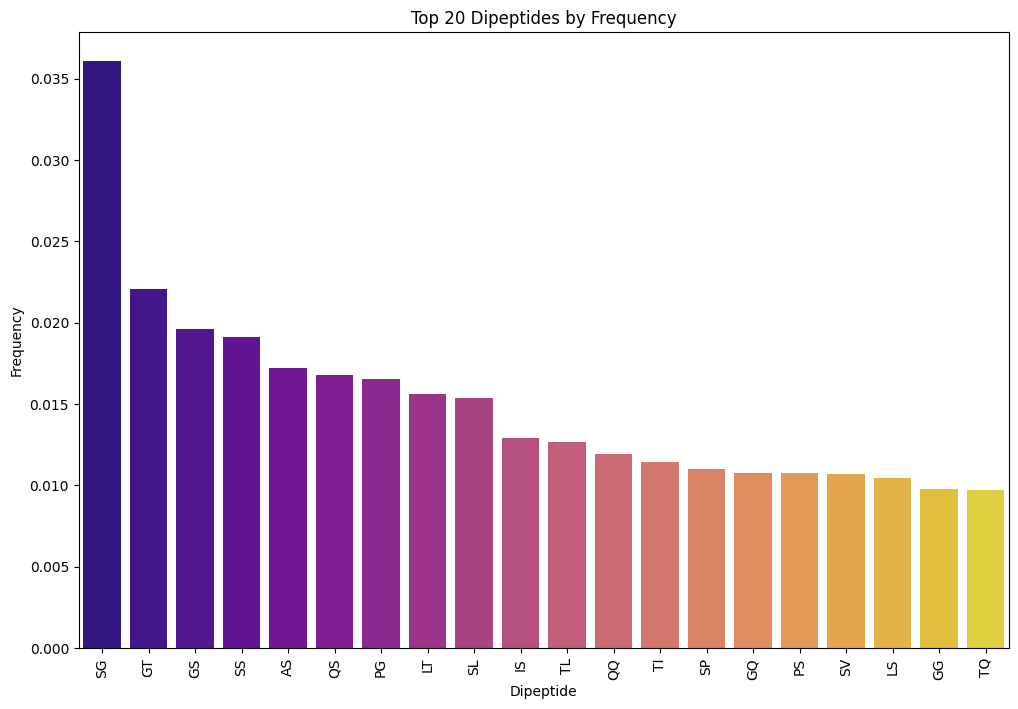

In [ ]:
# Example usage
fasta_file = 'Non-Amyloid.fasta'
perform_eda(fasta_file)

##Extraction of VL region of Sequences

In [ ]:
#Use this platform as reference: http://cao.labshare.cn/AbRSA/abrsa.php
sequences = read_fasta('Amyloid.fasta')
amyloid_CDR3 = []
counter = 1
for seq in sequences:
  for i in range(85,99):
    if "YC" == seq[i:i+2]:
      seq = seq[i+2:]
      break
    elif "CQ" == seq[i:i+2]:
      seq = seq[i+1:]
      break
    elif "QQ" == seq[i:i+2]:
      seq = seq[i:]
      break
    elif "W" == seq[i]:
      seq = seq[i-2:]
      break
    elif "C" == seq[i]:
      seq = seq[i+1:]
      break
  for j in range(6,20):
    if "FG" == seq[j:j + 2]:
      seq = seq[:j]
      break
    elif "FA" == seq[j:j + 2]:
      seq = seq[:j]
      break
  #print(2*counter, ": ", seq)
  counter += 1
  amyloid_CDR3.append(seq)
print(amyloid_CDR3)

['QQANFFPRT', 'QQYNDYPRT', 'QQYNDYPRT', 'QQYTNYPIT', 'QQYDSYPLT', 'QQYSTYPIT', 'QQYRSYPVT', 'QQYNSYPPT', 'QQYNNYPRT', 'QQYDSFPYT', 'QQYKSYPYT', 'QQYNSYPPT', 'QQYNNYPRT', 'QQYKSYPYT', 'QQYNIYPFT', 'QQYDSYPLT', 'QKYNSAPFS', 'QEYSSDWT', 'QQYYSSYT', 'QHYSSYPYT', 'QQYNTYPYT', 'HQYNSDIGVT', 'QQYNSYRYT', 'QQYNTYSRT', 'QQYNSYPYN', 'QQAFSFPIT', 'QQANSFPYT', 'QQYDTFPLT', 'QQYKTFPFP', 'QQYHSYPLT', 'QQYNDHLGT', 'QQYDDLPYT', 'QQYENLPLT', 'QQYASVFFT', 'QQYDNLPIT', 'QQYYNLPIT', 'QQYETLPT', 'QQYDNLPLT', 'QQYDKFPYT', 'QQYHNLPIT', 'QQYYNIPYT', 'QQYDNVPRFT', 'QHYYNFPFS', 'QQYNNLPPFT', 'QQYSDVPYT', 'QQFQNLPIT', 'QQYESLFT', 'QQYDYLPYT', 'QQYDNLPPFT', 'QQYDDLPYT', 'QQYDNLPIT', 'QQYDSLPYT', 'QQYHNLPPYT', 'QQYDNLPYT', 'QQYDSFPYT', 'QQYDFVPLT', 'QHYDDFPFT', 'QQYDHLPYT', 'QQYDDLPFT', 'QQYDSLPYT', 'QQYDNLPLT', 'QQYANLVT', 'QQYDKFPYT', 'QQYDNLPLT', 'QQYDNLPLT', 'QQYSNLPFT', 'QQYDNLPLT', 'QQYANLVT', 'QQYNNLPPFT', 'QQYNDLPPT', 'QQHADFPYT', 'QQSYTNPEVT', 'QQTYTTPFT', 'QQSYTTPYT', 'QQSYSNPLT', 'QQSYTTVIT', 'QQSYSTPRL

In [ ]:
sequences = read_fasta('Non-Amyloid.fasta')
non_amyloid_CDR3 = []
counter = 1
for seq in sequences:
  for i in range(85,99):
    if "YC" == seq[i:i+2]:
      seq = seq[i+2:]
      break
    elif "CQ" == seq[i:i+2]:
      seq = seq[i+1:]
      break
    elif "QQ" == seq[i:i+2]:
      seq = seq[i:]
      break
    elif "W" == seq[i]:
      seq = seq[i-2:]
      break
    elif "C" == seq[i]:
      seq = seq[i+1:]
      break
  for j in range(6,20):
    if "FG" == seq[j:j + 2]:
      seq = seq[:j]
      break
    elif "FA" == seq[j:j + 2]:
      seq = seq[:j]
      break
  #print(2*counter, ": ", seq)
  #counter += 1
  if len(seq) <= 16:
    non_amyloid_CDR3.append(seq)

print(len(non_amyloid_CDR3))

1468


In [ ]:
random.seed(10)
# Randomly select the specified number of elements from the list
#shorted_non_amyloid_CDR3 = random.sample(non_amyloid_CDR3, len(amyloid_CDR3))
shorted_non_amyloid_CDR3 = non_amyloid_CDR3


##Feature Extraction-Dipeptide Composition(DPC)

In [ ]:
from collections import defaultdict
import itertools

def calculate_dipeptide_composition(sequence):
    #Calculates the dipeptide composition of a protein sequence.
    # Initialize a dictionary for all possible dipeptides
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    dipeptides = [''.join(pair) for pair in itertools.product(amino_acids, repeat=2)]
    dpc = defaultdict(int, {dipeptide: 0 for dipeptide in dipeptides})

    # Count occurrences of each dipeptide
    for i in range(len(sequence) - 1):
        dipeptide = sequence[i:i+2]
        if dipeptide in dpc:
            dpc[dipeptide] += 1

    # Normalize the dipeptide counts by the total number of dipeptides
    total_dipeptides = len(sequence) - 1
    if total_dipeptides > 0:
        for dipeptide in dpc:
            dpc[dipeptide] /= total_dipeptides

    return dpc

def extract_dpc_features(sequences):
    #Extracts dipeptide composition features from all sequences
    features = []

    for seq in sequences:
        dpc = calculate_dipeptide_composition(seq)
        features.append(dpc)

    return features

# Calculate DPC for Non Amyloid sequences
sequences = shorted_non_amyloid_CDR3
dpc_features_non_amyloid_CDR3 = extract_dpc_features(sequences)

# Print features for each sequence
for i, features in enumerate(dpc_features_non_amyloid_CDR3):
    print(f"Sequence {i+1} DPC Features:")
    for dipeptide, frequency in sorted(features.items()):
        print(f"{dipeptide}: {frequency:.4f}")
    print()

print("Row dimension:", len(dpc_features_non_amyloid_CDR3)) #349
print("Column dimension:", len(dpc_features_non_amyloid_CDR3[0])) #400

Se han truncado las últimas 5000 líneas del flujo de salida.
NI: 0.0000
NK: 0.0000
NL: 0.0000
NM: 0.0000
NN: 0.0000
NP: 0.0000
NQ: 0.0000
NR: 0.0000
NS: 0.0000
NT: 0.1250
NV: 0.0000
NW: 0.0000
NY: 0.0000
PA: 0.0000
PC: 0.0000
PD: 0.0000
PE: 0.0000
PF: 0.0000
PG: 0.0000
PH: 0.0000
PI: 0.0000
PK: 0.0000
PL: 0.0000
PM: 0.0000
PN: 0.0000
PP: 0.0000
PQ: 0.0000
PR: 0.0000
PS: 0.0000
PT: 0.0000
PV: 0.0000
PW: 0.0000
PY: 0.0000
QA: 0.0000
QC: 0.0000
QD: 0.0000
QE: 0.0000
QF: 0.0000
QG: 0.0000
QH: 0.0000
QI: 0.0000
QK: 0.0000
QL: 0.0000
QM: 0.0000
QN: 0.0000
QP: 0.0000
QQ: 0.0000
QR: 0.0000
QS: 0.0000
QT: 0.0000
QV: 0.0000
QW: 0.0000
QY: 0.1250
RA: 0.0000
RC: 0.0000
RD: 0.0000
RE: 0.0000
RF: 0.0000
RG: 0.0000
RH: 0.0000
RI: 0.0000
RK: 0.0000
RL: 0.0000
RM: 0.0000
RN: 0.0000
RP: 0.0000
RQ: 0.0000
RR: 0.0000
RS: 0.0000
RT: 0.0000
RV: 0.0000
RW: 0.0000
RY: 0.0000
SA: 0.0000
SC: 0.0000
SD: 0.1250
SE: 0.0000
SF: 0.0000
SG: 0.0000
SH: 0.0000
SI: 0.0000
SK: 0.0000
SL: 0.0000
SM: 0.0000
SN: 0.0000
SP: 

In [ ]:
# Calculate DPC for Amyloid sequences
sequences = amyloid_CDR3
dpc_features_amyloid_CDR3 = extract_dpc_features(sequences)

# Print features for each sequence
"""for i, features in enumerate(dpc_features_amyloid_CDR3):
    print(f"Sequence {i+1} DPC Features:")
    for dipeptide, frequency in sorted(features.items()):
        print(f"{dipeptide}: {frequency:.4f}")
    print()"""

'for i, features in enumerate(dpc_features_amyloid_CDR3):\n    print(f"Sequence {i+1} DPC Features:")\n    for dipeptide, frequency in sorted(features.items()):\n        print(f"{dipeptide}: {frequency:.4f}")\n    print()'

## Transform Data

In [ ]:
# Initialize an empty list to store each sequence's feature array for Non-Amyloid sequences
feature_arrays = []
for i, features in enumerate(dpc_features_non_amyloid_CDR3):
    # Convert each sequence's feature values to a NumPy array
    feature_array = np.array(list(features.values()))
    # Append the array to the list
    feature_arrays.append(feature_array)

# Stack all feature arrays vertically to form a 2D array
non_amyloid_X = np.vstack(feature_arrays)

# Output the 2D array
print(len(non_amyloid_X))
print(len(non_amyloid_X[0]))

349
400


In [ ]:
# Initialize an empty list to store each sequence's feature array for Amyloid sequences
feature_arrays = []
for i, features in enumerate(dpc_features_amyloid_CDR3):
    # Convert each sequence's feature values to a NumPy array
    feature_array = np.array(list(features.values()))
    # Append the array to the list
    feature_arrays.append(feature_array)

# Stack all feature arrays vertically to form a 2D array
amyloid_X = np.vstack(feature_arrays)

# Output the 2D array
print(len(amyloid_X))
print(len(amyloid_X[0]))

349
400


In [ ]:
#Stack both Amyloid and Non-Amyloid sequence features
X = np.vstack((non_amyloid_X, amyloid_X))
print(len(X))
print(len(X[0]))

698
400


In [ ]:
#Create labels vector y
y = np.concatenate((np.zeros(len(non_amyloid_X)), np.ones(len(amyloid_X))))
print(len(y))

698


## Dimensionality Reduction with Maximum Relevance Minimum Redundancy(mRMR)



In [ ]:
number_of_features = 45
# Convert the NumPy arrays into a DataFrame
# Combine X and y into one DataFrame
df = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(X.shape[1])])
# Add the labels as the last column
df['Label'] = y
# Assuming you have a pandas DataFrame `X` for features and a Series `y` for labels
# Combine features and target labels into a single DataFrame
#data = pd.concat([X, y], axis=1)
#print(df)
# Use mRMR to select a subset of features
selected_features = pymrmr.mRMR(df, 'MIQ', number_of_features)  # 'MIQ' is for Max-Relevance, Min-Redundancy, selecting 20 features

# Output the selected feature names
print("Selected features: ", selected_features)
# Subset the original feature matrix to keep only the selected features
columns = [df.columns.get_loc(j) for j in selected_features]
X_selected = df[selected_features]
#print("X selected: ", X_selected)


Selected features:  ['Feature_271', 'Feature_272', 'Feature_268', 'Feature_269', 'Feature_270', 'Feature_266', 'Feature_264', 'Feature_273', 'Feature_274', 'Feature_275', 'Feature_267', 'Feature_277', 'Feature_265', 'Feature_258', 'Feature_259', 'Feature_255', 'Feature_256', 'Feature_257', 'Feature_278', 'Feature_263', 'Feature_260', 'Feature_261', 'Feature_262', 'Feature_276', 'Feature_253', 'Feature_296', 'Feature_297', 'Feature_293', 'Feature_294', 'Feature_295', 'Feature_291', 'Feature_289', 'Feature_298', 'Feature_299', 'Feature_300', 'Feature_292', 'Feature_252', 'Feature_290', 'Feature_283', 'Feature_284', 'Feature_280', 'Feature_281', 'Feature_282', 'Feature_279', 'Feature_288', 'Feature_285', 'Feature_286', 'Feature_287', 'Feature_254', 'Feature_302', 'Feature_221', 'Feature_222', 'Feature_218', 'Feature_219', 'Feature_220', 'Feature_216', 'Feature_214', 'Feature_223', 'Feature_224', 'Feature_225', 'Feature_217', 'Feature_227', 'Feature_215', 'Feature_208', 'Feature_209', 'Fea

## Train & Test Model

In [ ]:
# Now you can train your SVM model with the selected features
from sklearn.svm import SVC

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py
svm_model = SVC(kernel='rbf', class_weight={1: 3})

# Train the model
svm_model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Step 4: Evaluate the model

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification report: includes precision, recall, F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 74.29%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       118
         1.0       0.68      0.79      0.73        92

    accuracy                           0.74       210
   macro avg       0.74      0.75      0.74       210
weighted avg       0.75      0.74      0.74       210

Confusion Matrix:
[[83 35]
 [19 73]]


In [ ]:
word = "data.txt"
print(word)
word = word[2:-4]
print(word)

data.txt
ta
